In [1]:
#import python 3.6 modules
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#Import dataset
dfor = pd.read_csv(r'C:\Users\rlangran\Desktop\UT Data Analytics\Section 5\default of credit card clients1.csv', header =1)

#change name of default field
dfor.rename(columns={'default payment next month':'DEFAULT_IND'}, inplace=True)

#copy original dataset for further feature engineering
df = dfor
#copy original dataset for exploratory analysis
dfplt = dfor

(array([13388., 11326.,  4442.,   799.,    45.]),
 array([21. , 32.6, 44.2, 55.8, 67.4, 79. ]),
 <a list of 5 Patch objects>)

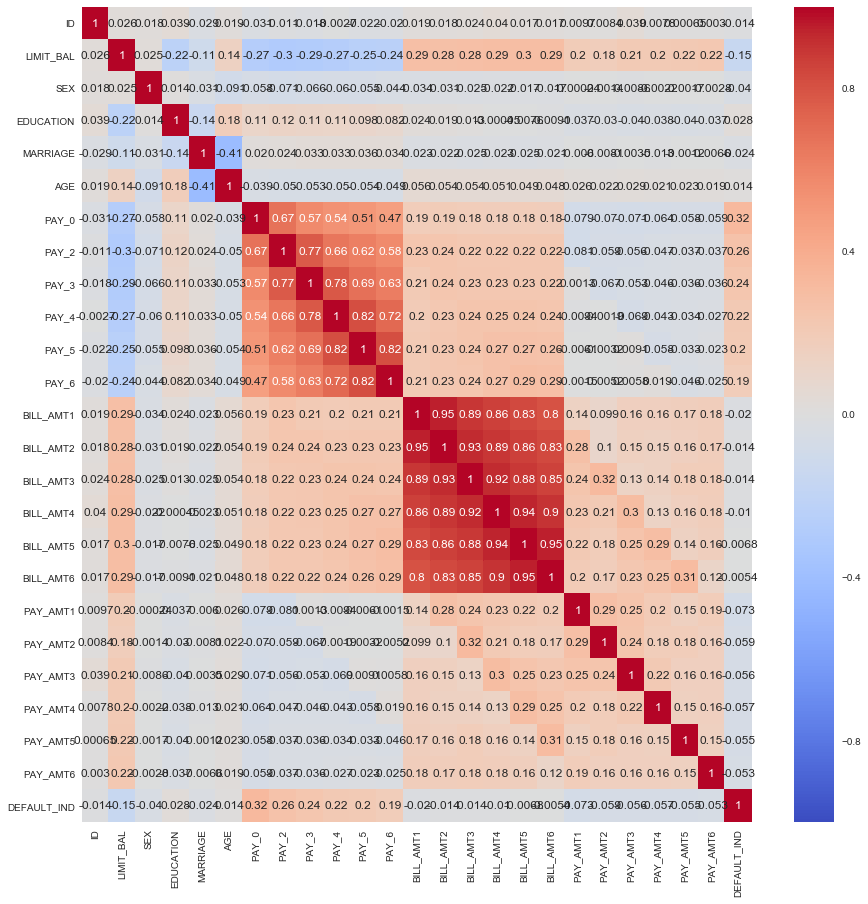

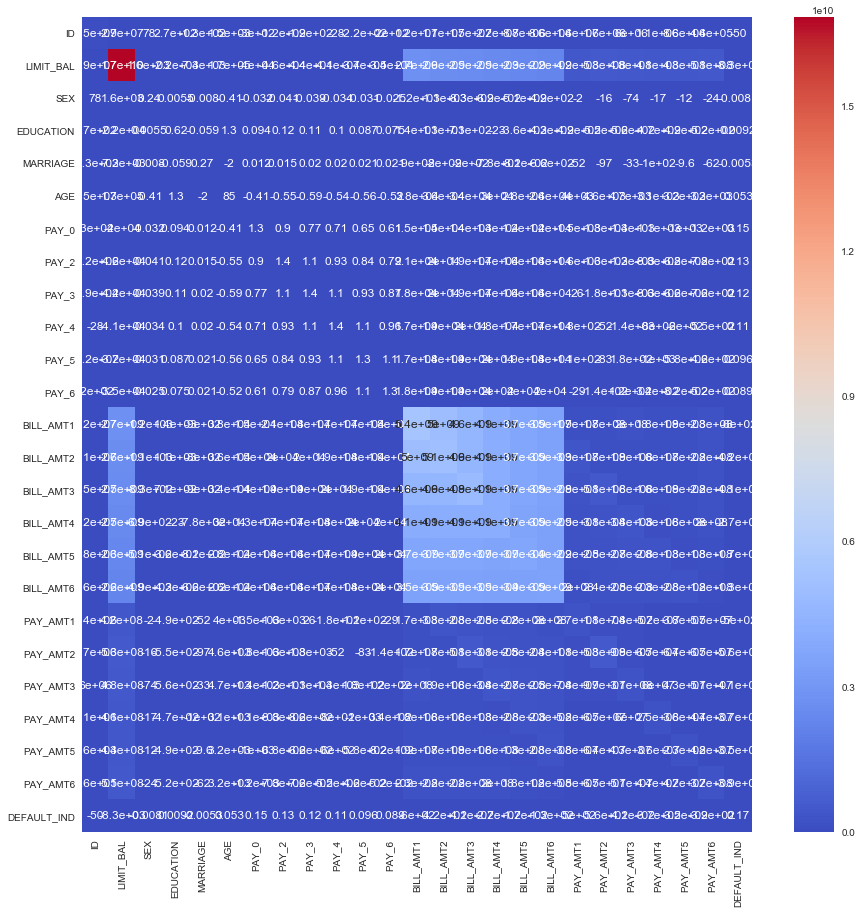

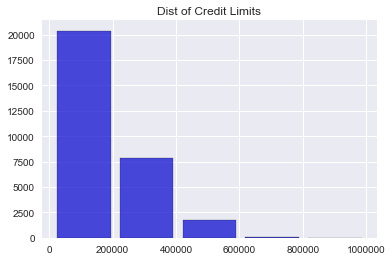

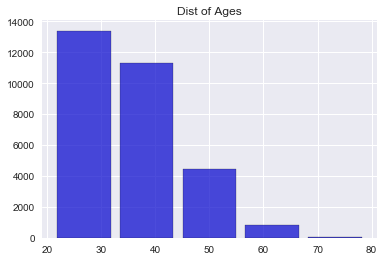

In [3]:
#plot heatmaps for correlation and covariance
sns.set(font_scale=1)
plt.figure(figsize=(15,15))
sns.heatmap(dfplt.corr(),vmin=-1,cmap='coolwarm',annot=True);

plt.figure(figsize=(15,15))
sns.heatmap(dfplt.cov(),vmin=-1,cmap='coolwarm',annot=True);

#plot histograms for credit limit and age
fig1, ax7 = plt.subplots()
ax7.set_title('Dist of Credit Limits')
ax7.hist(df['LIMIT_BAL'], bins=5, color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k")

fig1, ax8 = plt.subplots()
ax8.set_title('Dist of Ages')
ax8.hist(df['AGE'], bins=5, color='mediumblue',alpha=0.7, rwidth=0.85,edgecolor="k")

In [4]:
#setup feature scaling
#create separate dataframe for scaling
dftrim = (df[['BILL_AMT1','BILL_AMT3','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']])
x = dftrim.values
#min-max method
min_max_scaler = preprocessing.MinMaxScaler(feature_range =(0, 1))
#transform scaling 
x_after_min_max_scaler = min_max_scaler.fit_transform(x)
#setup new dataframe with scaled features
dfminmax = (pd.DataFrame(x_after_min_max_scaler, columns=['BILL_AMT1s','BILL_AMT3s','BILL_AMT6s','PAY_AMT1s',
                                                          'PAY_AMT2s','PAY_AMT3s','PAY_AMT4s','PAY_AMT5s','PAY_AMT6s']))

In [5]:
#feature engineering - age and limit bins
labels = ['1','2','3','4','5']
df['age_bin'] = pd.cut(df['AGE'], bins=5,labels=labels)
df['limit_bin'] = pd.cut(df['LIMIT_BAL'], bins=5,labels=labels)
#feature engineering - change datatypes
df['DEFAULT_IND'] = df['DEFAULT_IND'].astype(str)
df['PAY_0'] = df['PAY_0'].astype(str)
df['PAY_2'] = df['PAY_2'].astype(str)
df['PAY_3'] = df['PAY_3'].astype(str)
df['PAY_5'] = df['PAY_5'].astype(str)

In [13]:
#create final dataset and trim outliers
finaldfmm1 = (pd.concat([df['LIMIT_BAL'],df['limit_bin'],df['age_bin'], df['PAY_0'],df['PAY_2'],df['PAY_3'],df['PAY_5'],
                        dfminmax,df['DEFAULT_IND']], axis=1, sort='False'))
#trim outliers - limit_bal
finaldfmm2 = finaldfmm1[finaldfmm1['LIMIT_BAL']<=500000]
x = finaldfmm2.iloc[:,2:-1]
y = finaldfmm2.iloc[:,-1:]
#train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y.values.ravel(),test_size=0.20,random_state=42)

In [14]:
#recursive feature engineering check
ols = linear_model.LinearRegression()
#Create recursive feature eliminator that scores features by mean squared errors
rfecv = RFECV(estimator=ols, step=1, scoring='neg_mean_squared_error')
#Fit recursive feature eliminator 
rfecv.fit(X_train, y_train)
#Recursive feature elimination
rfecv.transform(X_train)
#summarize the selection of the attributes
print(rfecv.support_)
print(rfecv.ranking_)
print(rfecv.n_features_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
14


In [15]:
#removed 'PAY_4' and 'PAY_6' after RFE
#run prediction and score using SVM model
modelSVM = svm.SVC(kernel='linear') # Linear Kernel
modelSVM.fit(X_train, y_train)
y_predictsvm = modelSVM.predict(X_test)
print(confusion_matrix(y_test, y_predictsvm))
print(accuracy_score(y_test, y_predictsvm, normalize=True))

[[4561  153]
 [ 935  310]]
0.8174190300385971


In [16]:
#run prediction and score using kNN model
modelknn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
modelknn.fit(X_train, y_train)
y_predictknn = modelknn.predict(X_test)
print(confusion_matrix(y_test, y_predictknn))
print(accuracy_score(y_test, y_predictknn, normalize=True))

[[4478  236]
 [ 821  424]]
0.822621245175365


In [17]:
#run prediction and score using RF model
#changed "n_estimators" to 100 and "max_features" to "auto"
modelRF = (RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features="auto", max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
modelRF.fit(X_train,y_train)
y_predictRF = modelRF.predict(X_test)
print(confusion_matrix(y_test, y_predictRF))
print(accuracy_score(y_test, y_predictRF, normalize=True))

[[4444  270]
 [ 781  464]]
0.8236281255244169


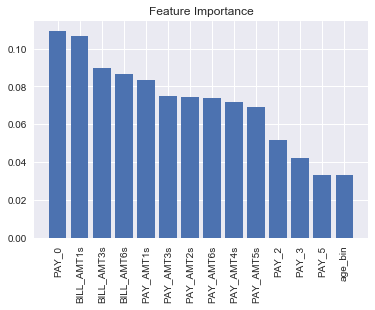

In [19]:
#verify RF results with feature importance
importances = modelRF.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
names = [x.columns[i] for i in indices]
# Create plot
plt.figure()
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X_test.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_test.shape[1]), names, rotation=90)
# Show plot
plt.show()

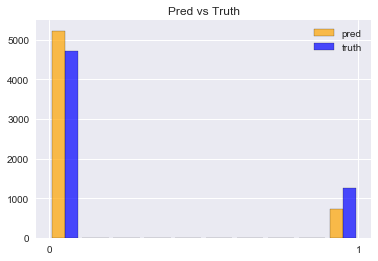

In [20]:
#visualization of final RF prediction vs ground truth
#convert values to dataframe
df1 = pd.DataFrame(y_predictRF, columns = ['pred'], index=None)
df2 = pd.DataFrame(y_test, columns = ['truth'], index=None)
df3 = pd.concat([df1,df2], axis=1, sort='False')
#plot as histogram
colors = ['orange', 'blue']
fig1, ax8 = plt.subplots()
ax8.set_title('Pred vs Truth')
ax8.hist(df3, alpha=0.7, rwidth=0.85,edgecolor="k",color=colors)
plt.legend(labels=['pred', 'truth'],loc='upper right')
plt.show()